In [3]:
"""
This is a notebook to walkthrough the process of clustering the combined data.

NOTE: For speedup, this notebook was ran in Google Colab. File paths will change
slightly as a result.
"""

# NOTE: These are some commands I had to run at the top of this notebook, to
# make it work in Google Colab.
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py
# !pip install umap-learn hdbscan geopandas matplotlib seaborn numpy pandas \
# umap-learn scikit-learn

# Load cuml extension to use a dGPU for calculations (which lead to much faster
# computation times)
#%load_ext cuml.accel

import geopandas as gpd
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap

from sklearn.preprocessing import StandardScaler

In [4]:
# Import data from previous notebook
df = pd.read_csv("merged_data_2022-07-20_to_2025-07-19.csv")
# df = pd.read_pickle("merged_data_2022-07-20_to_2025-07-19.pkl")
# df = pd.read_pickle("experimental_data/merged_data_2022-07-20_to_2025-07-19.pkl")

# Seems like a row can still have one or two rows with missing values even after filtering
# them out from the previous notebook, so I'll remove any more NA values here once again
df = df.dropna()
print(df.head())

/tmp/ipython-input-4-3620036135.py:2: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("merged_data_2022-07-20_to_2025-07-19.csv")


  dispatch_date        dispatch_time             address_block        lat  \
0    2025-05-02  2025-07-20 23:44:00       1100 BLOCK S 4TH ST  39.934248   
1    2025-05-12  2025-07-20 21:04:00  5100 BLOCK LANCASTER AVE  39.977061   
2    2025-04-23  2025-07-20 18:32:00      1700 BLOCK N 32ND ST  39.983588   
3    2025-04-24  2025-07-20 00:47:00   1300 BLOCK W Venango St  40.007425   
4    2025-02-26  2025-07-20 20:16:00       400 BLOCK N 35TH ST  39.961642   

         lon district_01 district_02 district_03 district_05 district_06  ...  \
0 -75.150833       False       False        True       False       False  ...   
1 -75.226406       False       False       False       False       False  ...   
2 -75.186199       False       False       False       False       False  ...   
3 -75.149843       False       False       False       False       False  ...   
4 -75.192723       False       False       False       False       False  ...   

  max_temp_f min_temp_f pop_total income_median me

The first significant step is to scale our data, as clustering is based on distance. This is to avoid
features that are naturally greater in range, take higher importance/precedence when clustered.

In [5]:
# Make a copy of the original dataframe, where all the preprocessing is done on
df_to_scale = df.copy()

# Initialize StandardScaler and config it to output a DataFrame
scaler = StandardScaler()
scaler.set_output(transform="pandas")

# Extract the columns to scale
numeric_cols = df_to_scale.select_dtypes(include=np.number).columns.tolist()
# NOTE: I do not want to scale the sinusoidal features as they are already in the desired range
cols_to_scale = [col for col in numeric_cols if "_sin" not in col and "_cos" not in col]

# Fit and transform the data
df_to_scale[cols_to_scale] = scaler.fit_transform(df_to_scale[cols_to_scale])

# Print the scaled data as sanity check
print(df_to_scale.head())

  dispatch_date        dispatch_time             address_block       lat  \
0    2025-05-02  2025-07-20 23:44:00       1100 BLOCK S 4TH ST -1.378139   
1    2025-05-12  2025-07-20 21:04:00  5100 BLOCK LANCASTER AVE -0.445529   
2    2025-04-23  2025-07-20 18:32:00      1700 BLOCK N 32ND ST -0.303347   
3    2025-04-24  2025-07-20 00:47:00   1300 BLOCK W Venango St  0.215896   
4    2025-02-26  2025-07-20 20:16:00       400 BLOCK N 35TH ST -0.781412   

        lon district_01 district_02 district_03 district_05 district_06  ...  \
0 -0.095679       False       False        True       False       False  ...   
1 -1.301896       False       False       False       False       False  ...   
2 -0.660161       False       False       False       False       False  ...   
3 -0.079873       False       False       False       False       False  ...   
4 -0.764277       False       False       False       False       False  ...   

  max_temp_f min_temp_f pop_total income_median median_age pov

Now, the data is ready for applying UMAP. This is a non-linear dimensionality
reduction algorithm, based on topology (allowing it to capture those non-linear patterns). This is
used, as clustering our data with over 80 columns can easily lead to the curse of dimensionality,
leading to much higher computational time and overfitting.

However, some columns in the data cannot be used here, so I drop them - They will be re-added later
as part of the final analysis.

In [6]:
columns_to_drop = [
    "dispatch_date",
    "dispatch_time",
    "address_block",
    "dispatch_date_dt",
    "geometry",
    "tract_id",
]

df_umap_ready = df_to_scale.drop(columns=columns_to_drop)

In [7]:
# Initialize UMAP. I'll stick with some static parameters for this experimental notebook.
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

# Fit and transform the data
df_embedding = reducer.fit_transform(df_umap_ready).astype("float64")

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


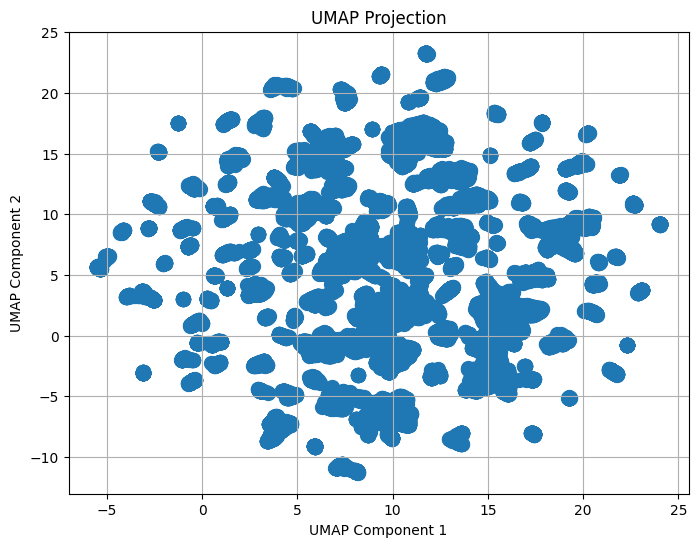

In [8]:
# Visualize the embedded data from UMAP
plt.figure(figsize=(8, 6))
plt.scatter(df_embedding[:, 0], df_embedding[:, 1], s=100)
plt.title("UMAP Projection")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.show()

From this, it's clear that there are lots of small clusters. Past that, it's hard to distinquish between them though.

At this point, I apply HDBSCAN to cluster this embedded data, to hopefully
shine some further light into the data.

In [14]:
# Initialize HDBSCAN object, again with some starting parameters for this
# notebook
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2000, min_samples=40, gen_min_span_tree=True
)

# Fit the HDBSCAN model with the UMAP embedded data
clusterer.fit(df_embedding)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN(gen_min_span_tree=True, min_cluster_size=2000, min_samples=40)

Now, I want to evaluate how well the clustering is. This is a bit open ended in nature, given that there is no pre-defined "true" label for the cluster.
Instead, I use a combination of 3 metrics to calculate a common score of sorts.

The first is the DBCV score. This measures how well points within each cluster
are clustered together, and how well separated individual clusters are. This
has a range of -1 to 1, with 1 having perfect clusters, 0 suggesting an ambigiuous cluster structure, and -1 indicating points likely being assigned to the wrong cluster - Ideal scores are positive as close to 1.

The second is the proportion of noise. This is just the proportion of our data that was considered an outlier by HDBSCAN. Lower is better, of course.

The third is the number of clusters. HDBSCAN is unique in that it will automatically determine the best number of clusters (compared to other algorithms where this is pre-defined), but we do not want to have a ton of clusters, which is quite possible with the scale of the data being used. To some degree, this wants to be minimized.

I define a custom metric combining all three as follows:
$$
\text{Score}_{\text{custom}} = (\text{Score}_{\text{DBCV}} - P_{\text{noise}}) - \alpha \cdot \ln(1 + N_{\text{clusters}})
$$
This subtracts the DBCV score with the proportion of noise, and then subtracts by a log transformation of the # of clusters. Given the range of all the other metrics, the range of my new custom metric is roughly negative infinity to 0.89 (this upper bound is with a DBCV score of 1, noise proportion of 0, and 2 clusters). In broader terms, the higher this custom score is, the better.

In [15]:
# Extract the cluster labels from the model
labels = clusterer.labels_

# Get DBCV score
dbcv_score = clusterer.relative_validity_

# Get noise proportion
noise_prop = np.sum(labels == -1) / len(labels)

# Get # of clusters
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Define a custom score combining the DBCV score, proportion of noise, and
# number of clusters
custom_score = (dbcv_score - noise_prop) - (0.1 * np.log1p(num_clusters))
print(num_clusters)
print(f"Custom score (higher is better): {custom_score}")

14
Custom score (higher is better): -0.3434367833433882


Overall, this is not too bad. Given the scale of the crime data I am using, I cannot realistically expect this to be very high, but at least for the static copy of the data stored from the previous notebook, this is fairly decent! More work can be done of course, but that's a whole other can of worms I will not worry about for now.

From here, I try to highlight each cluster with the UMAP embedded data.

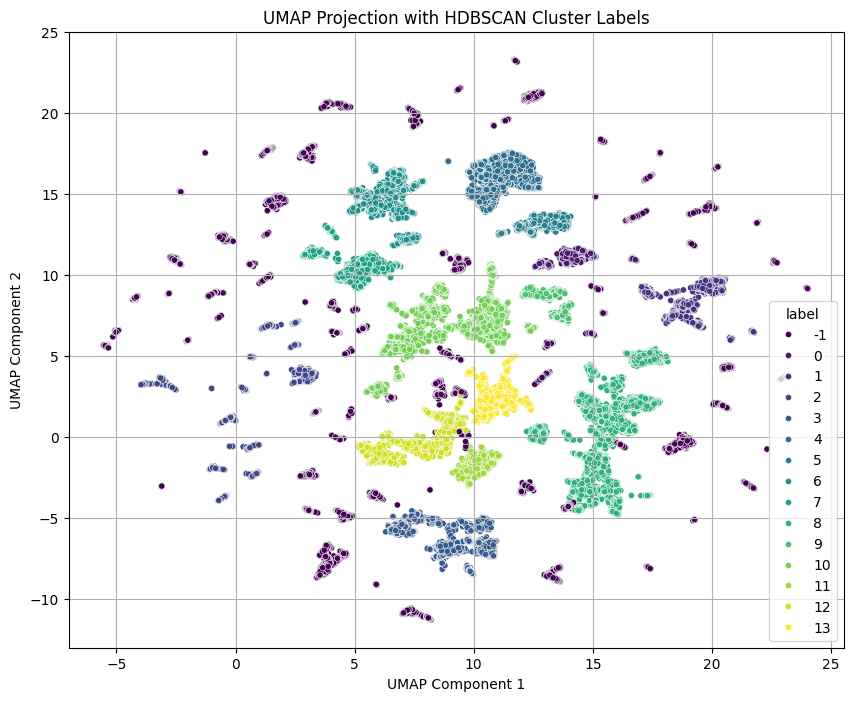

In [16]:
# Add the cluster labels to the UMAP embedded data
df_embedding_labeled = pd.DataFrame(
    df_embedding, columns=["UMAP Component 1", "UMAP Component 2"]
)
df_embedding_labeled["label"] = labels

# Display the UMAP data with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="UMAP Component 1",
    y="UMAP Component 2",
    hue="label",
    data=df_embedding_labeled,
    palette="viridis",
    s=20,
    legend="full",
)
plt.title("UMAP Projection with HDBSCAN Cluster Labels")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.show()

Admittedly, this plot is not the best. Since there are so many clusters, it is hard to distinquish between them. What can be seen though, is that many of the smaller clusters (or individual clusters) do group up accordingly. This is good to verify that HDBSCAN is indeed working (e.g. having dots without any pattern of the color would be more concerning).

The final task now, is just adding the cluster labels back to the original dataframe.

In [17]:
# Adding a new cluster label column to the original dataframe, `df`, without the
# scaled data. This is for the final bit of EDA, and we do not want to perform
# that with the scaled data.

df["cluster_label"] = labels
print(df.head())

  dispatch_date        dispatch_time             address_block        lat  \
0    2025-05-02  2025-07-20 23:44:00       1100 BLOCK S 4TH ST  39.934248   
1    2025-05-12  2025-07-20 21:04:00  5100 BLOCK LANCASTER AVE  39.977061   
2    2025-04-23  2025-07-20 18:32:00      1700 BLOCK N 32ND ST  39.983588   
3    2025-04-24  2025-07-20 00:47:00   1300 BLOCK W Venango St  40.007425   
4    2025-02-26  2025-07-20 20:16:00       400 BLOCK N 35TH ST  39.961642   

         lon district_01 district_02 district_03 district_05 district_06  ...  \
0 -75.150833       False       False        True       False       False  ...   
1 -75.226406       False       False       False       False       False  ...   
2 -75.186199       False       False       False       False       False  ...   
3 -75.149843       False       False       False       False       False  ...   
4 -75.192723       False       False       False       False       False  ...   

  min_temp_f pop_total income_median median_age po

In [ ]:
# Save the data with the cluster labels (doing both .csv and .pkl for flexability)
# NOTE: It seems that running this in Google Colab reduces in only a subset of the data being 
# loaded, so the labeled data being exported will be a subset of the original. I'll just use this 
# subset in the third and final experimental notebook, but since this I'm not using Google Colab in 
# the automated pipeline, this should not be an issue then.
filepath_pkl = f"labeled_merged_data_2022-07-20_to_2025-07-19.pkl"
filepath_csv = f"labeled_merged_data_2022-07-20_to_2025-07-19.csv"
# filepath_pkl = f"experimental_data/labeled_merged_data_2022-07-20_to_2025-07-19.pkl"
# filepath_csv = f"experimental_data/labeled_merged_data_2022-07-20_to_2025-07-19.csv"
df.to_pickle(filepath_pkl)
df.to_csv(filepath_csv)